# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, stats
from scipy.fft import fft
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [2]:
# Setting display options for better visualization in Jupyter
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

# Enable inline plotting for Jupyter
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')  #  nice style for plots

In [3]:
# 1. Data Loading Function
def load_signal_data(csv_path):
    """Load the signal data from CSV file"""
    df = pd.read_csv(csv_path)
    return df

In [4]:
df = load_signal_data('SR_tws.csv')
df.head()

,Time,Site Name,Point Machine Name,Direction,A Current,A Voltage,B Current,B Voltage,Type of A,Type of B,Polling of A,Polling of B
0,2025-02-10 05:25:23,WALAJAH ROAD JUNCTION,102,Reverse,"0.0,1.8,6.0,4.1,3.0,2.4,2.0,1.9,1.8,1.8,1.8,2....","0.0,16.5,54.0,82.5,99.0,106.5,111.0,112.5,112....","0.0,2.3,4.9,3.7,2.7,2.0,1.8,1.7,1.8,1.8,1.8,1....","0.0,15.0,55.5,84.0,100.5,109.5,112.5,114.0,115...",TWS,TWS,100,100.0
1,2025-02-10 09:38:24,WALAJAH ROAD JUNCTION,102,Normal,"0.0,0.0","0.0,0.0","0.0,2.3,5.2,3.5,2.7,2.2,1.8,1.8,1.9,1.9,1.9,2....","0.0,15.0,52.5,82.5,99.0,106.5,109.5,109.5,111....",TWS,TWS,100,100.0
2,2025-02-10 09:53:49,WALAJAH ROAD JUNCTION,102,Reverse,"0.0,3.0,5.8,3.9,2.8,2.3,1.9,1.9,1.8,1.8,1.8,1....","0.0,16.5,52.5,81.0,97.5,106.5,111.0,112.5,112....","0.0,3.4,4.9,3.6,2.6,2.0,1.8,1.7,1.8,1.7,1.7,1....","0.0,13.5,52.5,82.5,100.5,109.5,112.5,115.5,115...",TWS,TWS,100,100.0
3,2025-02-10 09:57:38,WALAJAH ROAD JUNCTION,102,Normal,"0.0,0.0","0.0,0.0","0.0,6.1,6.1,6.1,6.1,5.2,1.9,0.0,0.0,0.0,0.0,0....","0.0,94.5,94.5,93.0,93.0,93.0,93.0,93.0,93.0,93...",TWS,TWS,100,100.0
4,2025-02-10 09:59:20,WALAJAH ROAD JUNCTION,102,Normal,"0.0,0.0","0.0,0.0","0.9,5.5,4.2,3.1,2.5,2.0,1.8,1.7,1.7,1.8,1.8,2....","0.0,15.0,45.0,78.0,96.0,105.0,108.0,108.0,106....",TWS,TWS,100,100.0


In [5]:
df.shape

(20133, 12)

## 2. Array Parsing Function 

In [6]:
def parse_array(array_str):
    """Convert string representation of arrays into numpy arrays"""
    if pd.isna(array_str) or array_str == '0.0,0.0' or array_str == '0.0':
        return np.array([0.0, 0.0])
    
    # Handle cases where the string might be in list format
    if isinstance(array_str, str):
        if array_str.startswith('[') and array_str.endswith(']'):
            array_str = array_str[1:-1]
        elif array_str.startswith('(') and array_str.endswith(')'):
            array_str = array_str[1:-1]
    
    # Extract numbers using regex
    numbers = re.findall(r'-?\d+\.?\d*', array_str)  # Handles negative numbers too
    if not numbers:
        return np.array([0.0, 0.0])
    
    # Convert to float array
    try:
        return np.array([float(num) for num in numbers])
    except:
        return np.array([0.0, 0.0])

# 3. Data Cleaning and Preprocessing 

In [7]:
def preprocess_data(df):
    """Clean and preprocess the raw data"""
    # Convert timestamp to datetime
    df['Time'] = pd.to_datetime(df['Time'])
    
    # Parse array columns
    array_columns = ['A Current', 'A Voltage', 'B Current', 'B Voltage']
    for col in array_columns:
        df[col] = df[col].apply(parse_array)
    
    # Check array lengths
    for col in array_columns:
        df[col + '_length'] = df[col].apply(len)
    
    # Filter out rows with insufficient data
    min_length = 5  # Minimum number of data points required
    valid_mask = (df['A Current_length'] >= min_length) | (df['A Voltage_length'] >= min_length) | \
                (df['B Current_length'] >= min_length) | (df['B Voltage_length'] >= min_length)
    
    df_clean = df[valid_mask].copy()
    df_clean.drop([col + '_length' for col in array_columns], axis=1, inplace=True)
    
    return df_clean

In [8]:
df_clean = preprocess_data(df)

In [9]:
df_clean.head()

,Time,Site Name,Point Machine Name,Direction,A Current,A Voltage,B Current,B Voltage,Type of A,Type of B,Polling of A,Polling of B
0,2025-02-10 05:25:23,WALAJAH ROAD JUNCTION,102,Reverse,"[0.0, 1.8, 6.0, 4.1, 3.0, 2.4, 2.0, 1.9, 1.8, ...","[0.0, 16.5, 54.0, 82.5, 99.0, 106.5, 111.0, 11...","[0.0, 2.3, 4.9, 3.7, 2.7, 2.0, 1.8, 1.7, 1.8, ...","[0.0, 15.0, 55.5, 84.0, 100.5, 109.5, 112.5, 1...",TWS,TWS,100,100.0
1,2025-02-10 09:38:24,WALAJAH ROAD JUNCTION,102,Normal,"[0.0, 0.0]","[0.0, 0.0]","[0.0, 2.3, 5.2, 3.5, 2.7, 2.2, 1.8, 1.8, 1.9, ...","[0.0, 15.0, 52.5, 82.5, 99.0, 106.5, 109.5, 10...",TWS,TWS,100,100.0
2,2025-02-10 09:53:49,WALAJAH ROAD JUNCTION,102,Reverse,"[0.0, 3.0, 5.8, 3.9, 2.8, 2.3, 1.9, 1.9, 1.8, ...","[0.0, 16.5, 52.5, 81.0, 97.5, 106.5, 111.0, 11...","[0.0, 3.4, 4.9, 3.6, 2.6, 2.0, 1.8, 1.7, 1.8, ...","[0.0, 13.5, 52.5, 82.5, 100.5, 109.5, 112.5, 1...",TWS,TWS,100,100.0
3,2025-02-10 09:57:38,WALAJAH ROAD JUNCTION,102,Normal,"[0.0, 0.0]","[0.0, 0.0]","[0.0, 6.1, 6.1, 6.1, 6.1, 5.2, 1.9, 0.0, 0.0, ...","[0.0, 94.5, 94.5, 93.0, 93.0, 93.0, 93.0, 93.0...",TWS,TWS,100,100.0
4,2025-02-10 09:59:20,WALAJAH ROAD JUNCTION,102,Normal,"[0.0, 0.0]","[0.0, 0.0]","[0.9, 5.5, 4.2, 3.1, 2.5, 2.0, 1.8, 1.7, 1.7, ...","[0.0, 15.0, 45.0, 78.0, 96.0, 105.0, 108.0, 10...",TWS,TWS,100,100.0


In [10]:
df_clean.shape

(20129, 12)

In [11]:
df_clean.isna().sum()

Time                      0
Site Name                 0
Point Machine Name        0
Direction                 0
A Current                 0
A Voltage                 0
B Current                 0
B Voltage                 0
Type of A                 0
Type of B             17242
Polling of A              0
Polling of B          17242
dtype: int64

In [12]:
# Filling Type of B with "TWS"
df_clean['Type of B'] = df_clean['Type of B'].fillna("TWS") 

 # Filling  Polling of B with 100.0
df_clean['Polling of B'] = df_clean['Polling of B'].fillna(100.0) 

In [13]:
df_clean.isna().sum()

Time                  0
Site Name             0
Point Machine Name    0
Direction             0
A Current             0
A Voltage             0
B Current             0
B Voltage             0
Type of A             0
Type of B             0
Polling of A          0
Polling of B          0
dtype: int64

# 4. Feature Extraction 

In [14]:
def extract_features(df):
    """Extract meaningful features from the signal data"""
    feature_df = pd.DataFrame()
    
    # Copy metadata columns
    metadata_cols = ['Time', 'Site Name', 'Point Machine Name', 'Direction', 'Type of A', 'Type of B']
    for col in metadata_cols:
        feature_df[col.replace(' ', '_')] = df[col]
    
    # Process each signal array
    signal_columns = ['A Current', 'A Voltage', 'B Current', 'B Voltage']
    
    for col in signal_columns:
        # Basic statistics
        feature_df[f'{col}_mean'] = df[col].apply(lambda x: np.mean(x) if len(x) > 0 else np.nan)
        feature_df[f'{col}_std'] = df[col].apply(lambda x: np.std(x) if len(x) > 0 else np.nan)
        feature_df[f'{col}_max'] = df[col].apply(lambda x: np.max(x) if len(x) > 0 else np.nan)
        feature_df[f'{col}_min'] = df[col].apply(lambda x: np.min(x) if len(x) > 0 else np.nan)
        feature_df[f'{col}_ptp'] = df[col].apply(lambda x: np.ptp(x) if len(x) > 0 else np.nan)  # Peak-to-peak
        
        # Time domain features
        feature_df[f'{col}_rms'] = df[col].apply(lambda x: np.sqrt(np.mean(np.square(x))) if len(x) > 0 else np.nan)
        feature_df[f'{col}_skew'] = df[col].apply(lambda x: stats.skew(x) if len(x) > 2 else np.nan)
        feature_df[f'{col}_kurtosis'] = df[col].apply(lambda x: stats.kurtosis(x) if len(x) > 2 else np.nan)
        
        # Rate of change features
        feature_df[f'{col}_max_diff'] = df[col].apply(lambda x: np.max(np.abs(np.diff(x))) if len(x) > 1 else np.nan)
        feature_df[f'{col}_mean_diff'] = df[col].apply(lambda x: np.mean(np.abs(np.diff(x))) if len(x) > 1 else np.nan)
        
        # Frequency domain features
        def get_fft_features(x):
            if len(x) < 5:
                return np.nan, np.nan, np.nan, np.nan
            
            n = len(x)
            yf = fft(x)
            xf = np.fft.fftfreq(n)
            
            # Get dominant frequency component (excluding DC)
            idx = np.argmax(np.abs(yf[1:n//2])) + 1
            dom_freq = xf[idx]
            dom_amp = np.abs(yf[idx])/n
            
            # Spectral energy
            energy = np.sum(np.square(np.abs(yf)))/n
            
            # Spectral centroid
            if np.sum(np.abs(yf)) > 0:
                centroid = np.sum(xf * np.abs(yf))/np.sum(np.abs(yf))
            else:
                centroid = np.nan
            
            return dom_freq, dom_amp, energy, centroid
        
        fft_features = df[col].apply(get_fft_features)
        feature_df[f'{col}_dom_freq'] = fft_features.apply(lambda x: x[0] if isinstance(x, tuple) else np.nan)
        feature_df[f'{col}_dom_amp'] = fft_features.apply(lambda x: x[1] if isinstance(x, tuple) else np.nan)
        feature_df[f'{col}_spectral_energy'] = fft_features.apply(lambda x: x[2] if isinstance(x, tuple) else np.nan)
        feature_df[f'{col}_spectral_centroid'] = fft_features.apply(lambda x: x[3] if isinstance(x, tuple) else np.nan)
    
    # Fill remaining NA values with column medians
    numeric_cols = feature_df.select_dtypes(include=[np.number]).columns
    feature_df[numeric_cols] = feature_df[numeric_cols].fillna(feature_df[numeric_cols].median())
    
    return feature_df

In [15]:
features = extract_features(df_clean)

In [16]:
df_clean.shape

(20129, 12)

# 5. Visualization 

In [17]:
def plot_signals(df, idx):
    """Plot the signal data for visual inspection"""
    if idx >= len(df):
        print(f"Index {idx} is out of range. Max index is {len(df)-1}")
        return
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    row = df.iloc[idx]
    
    # Plot A Current
    if len(row['A Current']) > 0:
        axs[0, 0].plot(row['A Current'])
        axs[0, 0].set_title(f"A Current - {row['Direction']}")
        axs[0, 0].set_ylabel('Current')
    else:
        axs[0, 0].text(0.5, 0.5, 'No Data', ha='center')
    
    # Plot A Voltage
    if len(row['A Voltage']) > 0:
        axs[0, 1].plot(row['A Voltage'])
        axs[0, 1].set_title(f"A Voltage - {row['Direction']}")
        axs[0, 1].set_ylabel('Voltage')
    else:
        axs[0, 1].text(0.5, 0.5, 'No Data', ha='center')
    
    # Plot B Current
    if len(row['B Current']) > 0:
        axs[1, 0].plot(row['B Current'])
        axs[1, 0].set_title(f"B Current - {row['Direction']}")
        axs[1, 0].set_ylabel('Current')
    else:
        axs[1, 0].text(0.5, 0.5, 'No Data', ha='center')
    
    # Plot B Voltage
    if len(row['B Voltage']) > 0:
        axs[1, 1].plot(row['B Voltage'])
        axs[1, 1].set_title(f"B Voltage - {row['Direction']}")
        axs[1, 1].set_ylabel('Voltage')
    else:
        axs[1, 1].text(0.5, 0.5, 'No Data', ha='center')
    
    plt.tight_layout()
    plt.suptitle(f"Signal Patterns for {row['Site Name']} - {row['Time']}", y=1.02)
    plt.show()

# 6. Feature Scaling and Dimensionality Reduction

In [18]:
def scale_and_reduce_dimensions(feature_df):
    """Scale features and perform dimensionality reduction"""
    # Select numerical features for clustering
    numeric_cols = feature_df.select_dtypes(include=['float64', 'int64']).columns
    
    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_df[numeric_cols])
    
    # Apply PCA to reduce dimensions
    pca = PCA(n_components=0.95)  # Capture 95% of variance
    reduced_features = pca.fit_transform(scaled_features)
    
    # Display PCA results
    print(f"Original features: {scaled_features.shape[1]}")
    print(f"Reduced features: {reduced_features.shape[1]}")
    
    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by Components')
    plt.grid(True)
    plt.show()
    
    return scaled_features, reduced_features, pca, numeric_cols


Original features: 56
Reduced features: 17


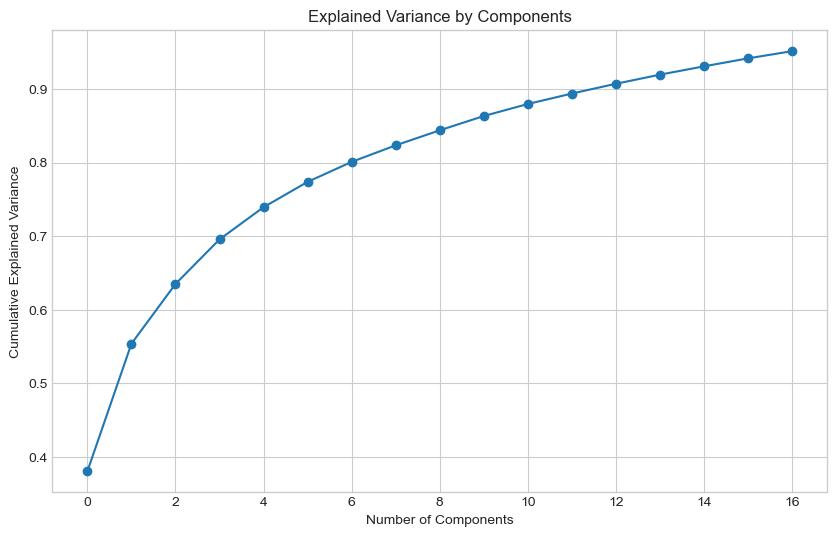

In [19]:
scaled_features, reduced_features, pca, numeric_cols = scale_and_reduce_dimensions(features)

# 7. Clustering Evaluation 

In [20]:
def evaluate_clustering(feature_df, scaled_features, reduced_features, n_clusters_range=range(2, 11)):
    """Evaluate different clustering algorithms"""
    results = []
    X = reduced_features  # Use reduced features for clustering
    
    # Evaluate KMeans
    kmeans_silhouette = []
    kmeans_ch = []
    
    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        
        sil_score = silhouette_score(X, labels)
        ch_score = calinski_harabasz_score(X, labels)
        
        kmeans_silhouette.append(sil_score)
        kmeans_ch.append(ch_score)
        
        results.append({
            'algorithm': 'KMeans',
            'n_clusters': n_clusters,
            'silhouette': sil_score,
            'calinski_harabasz': ch_score
        })
    
    # Evaluate GMM
    gmm_silhouette = []
    gmm_ch = []
    
    for n_clusters in n_clusters_range:
        gmm = GaussianMixture(n_components=n_clusters, random_state=42)
        labels = gmm.fit_predict(X)
        
        sil_score = silhouette_score(X, labels)
        ch_score = calinski_harabasz_score(X, labels)
        
        gmm_silhouette.append(sil_score)
        gmm_ch.append(ch_score)
        
        results.append({
            'algorithm': 'GMM',
            'n_clusters': n_clusters,
            'silhouette': sil_score,
            'calinski_harabasz': ch_score
        })
    
    # Evaluate DBSCAN with different parameters
    eps_values = [0.5, 0.75, 1.0, 1.25, 1.5, 2.0]
    min_samples_values = [3, 5, 10]
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            
            # Skip if all points are classified as noise (-1)
            if len(set(labels)) <= 1 or -1 in labels and sum(labels != -1) <= 1:
                continue
            
            # Calculate silhouette only for non-noise points
            if -1 in labels:
                mask = labels != -1
                if sum(mask) > 1:  # Need at least 2 points for silhouette
                    sil_score = silhouette_score(X[mask], labels[mask])
                    ch_score = calinski_harabasz_score(X[mask], labels[mask])
                else:
                    continue  # Skip if not enough non-noise points
            else:
                sil_score = silhouette_score(X, labels)
                ch_score = calinski_harabasz_score(X, labels)
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            
            results.append({
                'algorithm': 'DBSCAN',
                'n_clusters': n_clusters,
                'eps': eps,
                'min_samples': min_samples,
                'silhouette': sil_score,
                'calinski_harabasz': ch_score
            })
    
    # Convert results to dataframe
    results_df = pd.DataFrame(results)
    
    # Plot evaluation metrics - KMeans and GMM
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(n_clusters_range, kmeans_silhouette, marker='o', label='KMeans')
    plt.plot(n_clusters_range, gmm_silhouette, marker='s', label='GMM')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.legend()
    plt.title('Silhouette Score vs Number of Clusters')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.subplot(1, 2, 2)
    plt.plot(n_clusters_range, kmeans_ch, marker='o', label='KMeans')
    plt.plot(n_clusters_range, gmm_ch, marker='s', label='GMM')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Calinski-Harabasz Score')
    plt.legend()
    plt.title('Calinski-Harabasz Score vs Number of Clusters')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Display DBSCAN results if available
    dbscan_df = results_df[results_df['algorithm'] == 'DBSCAN']
    if not dbscan_df.empty:
        plt.figure(figsize=(12, 6))
        pivot_df = dbscan_df.pivot_table(index='eps', columns='min_samples', values='silhouette')
        sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.3f')
        plt.title('DBSCAN Silhouette Scores')
        plt.show()
    
    # Get best results for each algorithm
    best_results = {}
    for algorithm in results_df['algorithm'].unique():
        algo_df = results_df[results_df['algorithm'] == algorithm]
        best_idx = algo_df['silhouette'].idxmax()
        best_results[algorithm] = algo_df.loc[best_idx]
    
    # Display best results
    print("Best clustering parameters for each algorithm:")
    for algorithm, result in best_results.items():
        if algorithm == 'DBSCAN':
            print(f"{algorithm}: eps={result['eps']}, min_samples={int(result['min_samples'])}, "
                  f"silhouette={result['silhouette']:.3f}, CH={result['calinski_harabasz']:.1f}, "
                  f"clusters={int(result['n_clusters'])}")
        else:
            print(f"{algorithm}: n_clusters={int(result['n_clusters'])}, "
                  f"silhouette={result['silhouette']:.3f}, CH={result['calinski_harabasz']:.1f}")
    
    return results_df, best_results


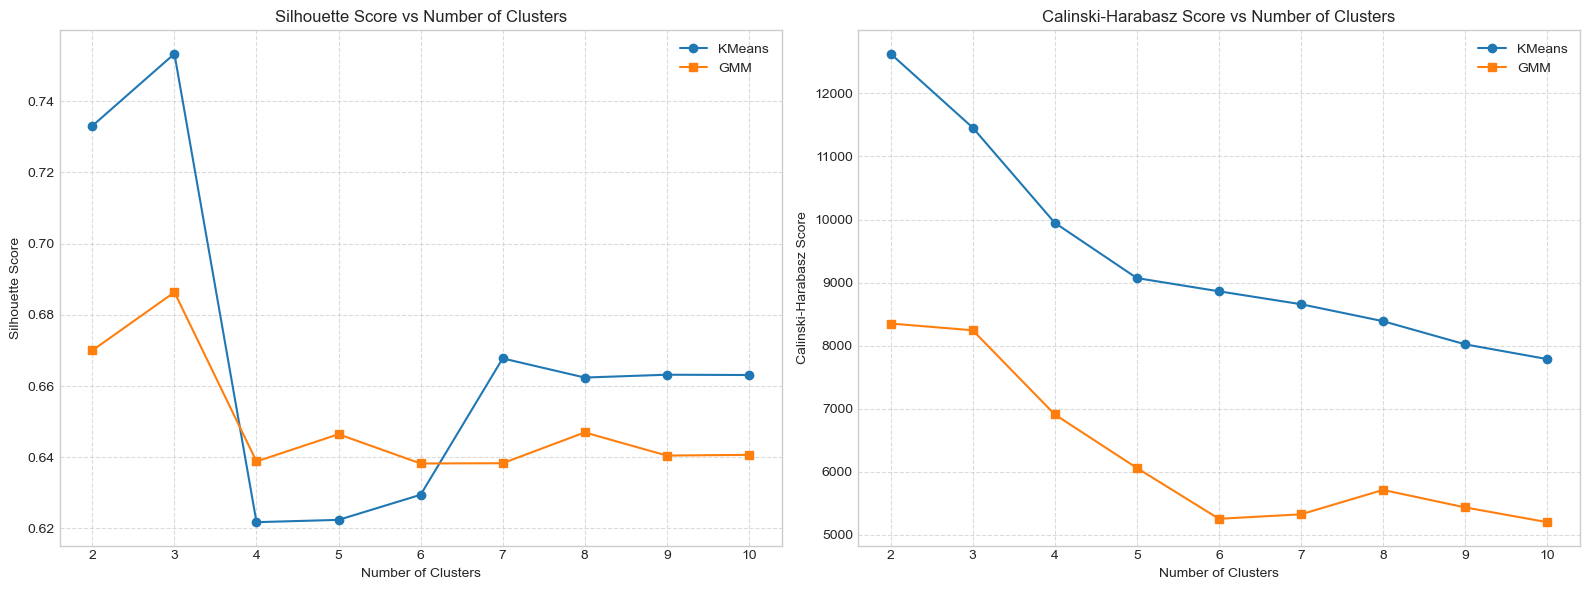

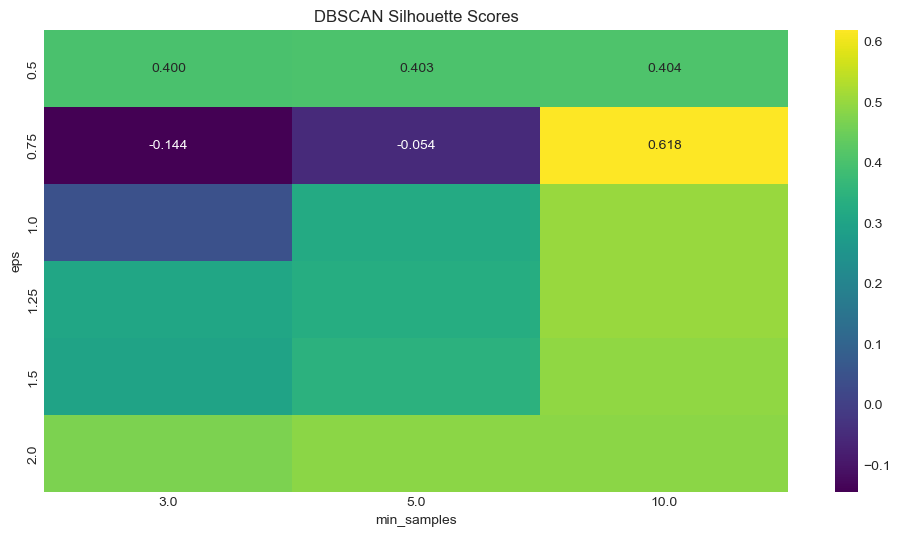

Best clustering parameters for each algorithm:
KMeans: n_clusters=3, silhouette=0.753, CH=11456.3
GMM: n_clusters=3, silhouette=0.686, CH=8244.2
DBSCAN: eps=0.75, min_samples=10, silhouette=0.618, CH=19530.4, clusters=13


In [21]:
results_df, best_results = evaluate_clustering(features, scaled_features, reduced_features)

# 8. Apply Best Clustering and Visualize Results

In [22]:
def apply_best_clustering(X, best_results):
    """Apply the best clustering algorithm based on evaluation"""
    # Find the algorithm with highest silhouette score
    best_algorithm = max(best_results.items(), key=lambda x: x[1]['silhouette'])[0]
    best_params = best_results[best_algorithm]
    
    print(f"Selected algorithm: {best_algorithm} with silhouette score: {best_params['silhouette']:.3f}")
    
    # Apply selected algorithm
    if best_algorithm == 'KMeans':
        model = KMeans(n_clusters=int(best_params['n_clusters']), random_state=42, n_init=10)
    elif best_algorithm == 'GMM':
        model = GaussianMixture(n_components=int(best_params['n_clusters']), random_state=42)
    elif best_algorithm == 'DBSCAN':
        model = DBSCAN(eps=best_params['eps'], min_samples=int(best_params['min_samples']))
    
    labels = model.fit_predict(X)
    
    return model, labels, best_algorithm


In [23]:
model, labels, best_algorithm = apply_best_clustering(reduced_features, best_results)

Selected algorithm: KMeans with silhouette score: 0.753


# 9. Visualize Clusters 

In [30]:
def visualize_2d_clusters(scaled_features, labels, pca):
    """Visualize clusters in 2D using PCA-transformed features"""
    # Transform to 2D using PCA
    X_2d = pca.transform(scaled_features)[:, :2]
    
    # Create plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], 
                         c=labels, cmap='viridis', 
                         s=50, alpha=0.7)
    
    # Add legend for clusters
    plt.legend(*scatter.legend_elements(),
               title="Clusters", loc="best")
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('2D Cluster Visualization')
    plt.show()
    
    return X_2d

In [31]:
def visualize_3d_clusters(reduced_features, labels):
    """Visualize clusters in 3D using first 3 dimensions of reduced features"""
    # Ensure we have at least 3 dimensions
    if reduced_features.shape[1] < 3:
        print("Not enough dimensions for 3D visualization")
        return
    
    # Take first 3 dimensions
    X_3d = reduced_features[:, :3]
    
    # Create plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2],
                        c=labels, cmap='viridis',
                        s=50, alpha=0.7)
    
    # Add legend
    ax.legend(*scatter.legend_elements(),
              title="Clusters", loc="best")
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')
    ax.set_title('3D Cluster Visualization')
    plt.show()

## For 2D Visualization 

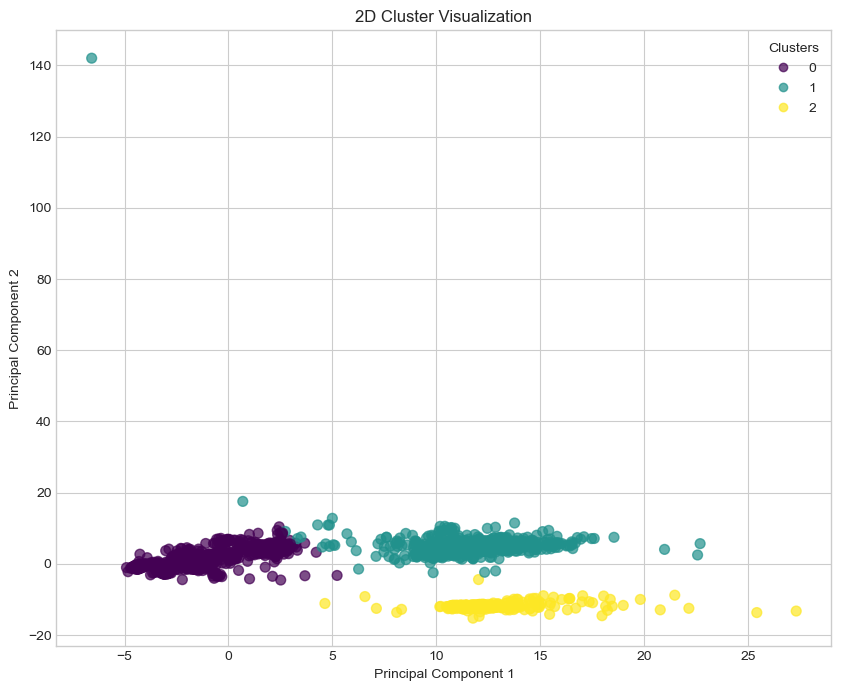

array([[  9.5409193 ,   4.40490089],
       [ 11.55494436, -12.19405026],
       [  9.70838639,   3.8627813 ],
       ...,
       [ 11.34090296,   4.66293   ],
       [ 11.56073345,   4.57409436],
       [ 12.29909522,   4.14063196]])

In [32]:
visualize_2d_clusters(scaled_features, labels, pca)

## For 3D Visualization 

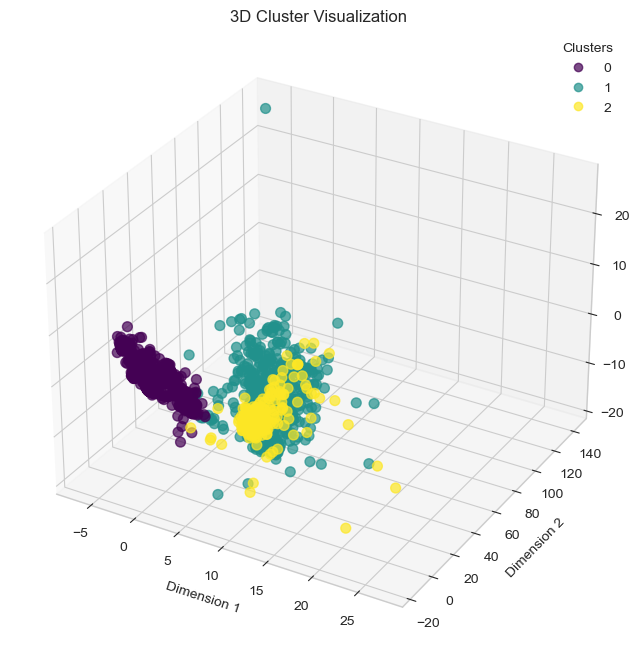

In [33]:
visualize_3d_clusters(reduced_features, labels)

# 10. Analyze Cluster Characteristics 

In [34]:
def analyze_clusters(feature_df, labels, numeric_cols):
    """Analyze the characteristics of each cluster"""
    # Add cluster labels to the feature dataframe
    df_with_clusters = feature_df.copy()
    df_with_clusters['cluster'] = labels
    
    # Compute mean of each feature for each cluster
    cluster_means = df_with_clusters.groupby('cluster')[numeric_cols].mean()
    
    # Create heatmap of feature means by cluster
    plt.figure(figsize=(18, 12))
    sns.heatmap(cluster_means, cmap='viridis', annot=False, linewidths=.5)
    plt.title('Mean Feature Values by Cluster')
    plt.tight_layout()
    plt.show()
    
    # Count samples in each cluster
    cluster_counts = df_with_clusters['cluster'].value_counts().sort_index()
    
    plt.figure(figsize=(10, 6))
    cluster_counts.plot(kind='bar')
    plt.title('Number of Samples in Each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Analyze relationships between clusters and categorical variables
    categorical_cols = ['Direction', 'Type_A', 'Type_B']
    for col in categorical_cols:
        if col in df_with_clusters.columns:
            plt.figure(figsize=(12, 6))
            pd.crosstab(df_with_clusters['cluster'], df_with_clusters[col]).plot(
                kind='bar', stacked=True)
            plt.title(f'Distribution of {col} by Cluster')
            plt.xlabel('Cluster')
            plt.ylabel('Count')
            plt.legend(title=col)
            plt.tight_layout()
            plt.show()
    
    return df_with_clusters, cluster_means

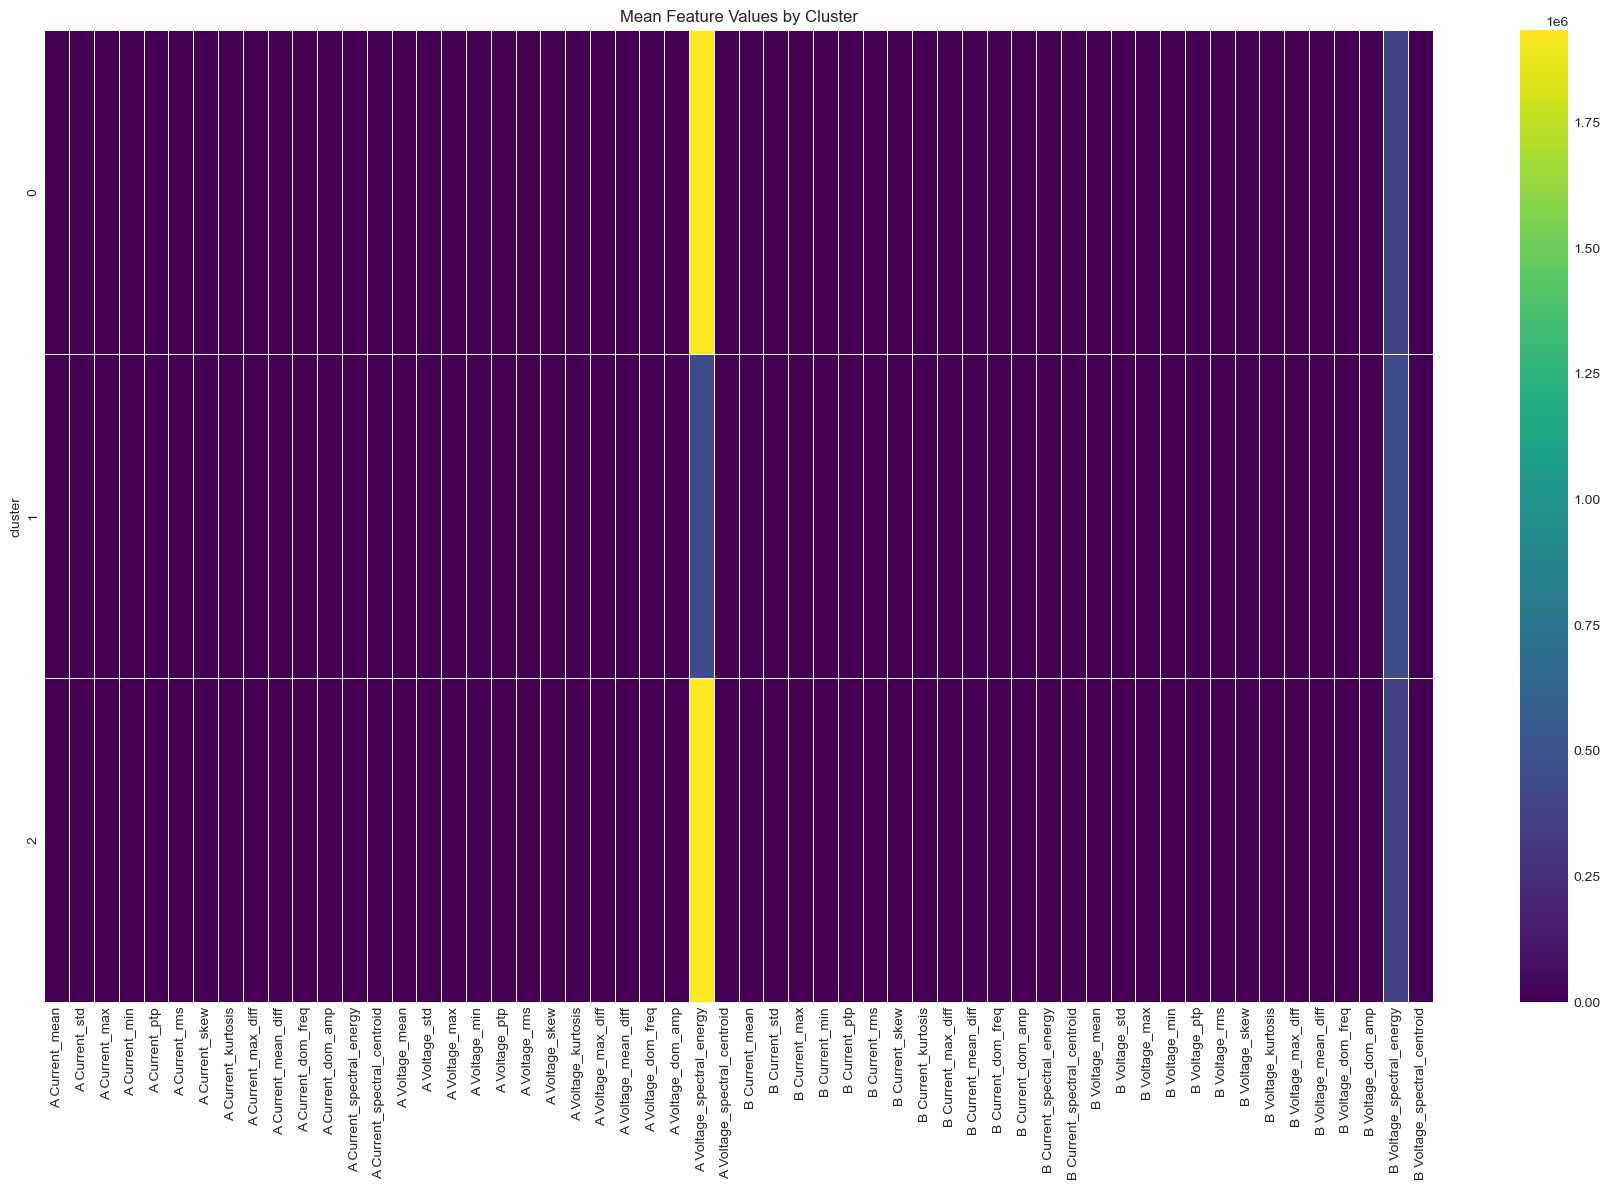

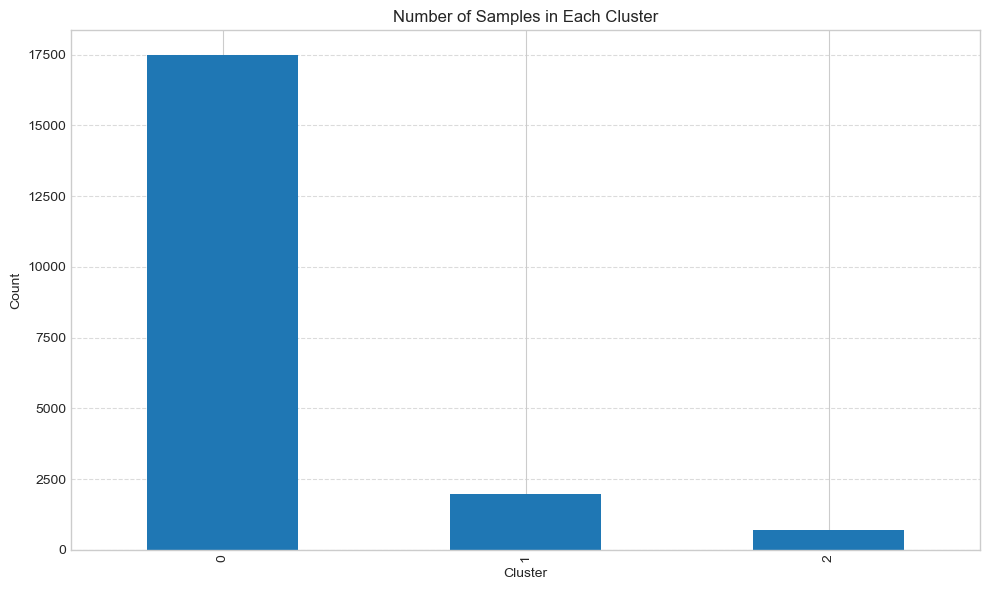

<Figure size 1200x600 with 0 Axes>

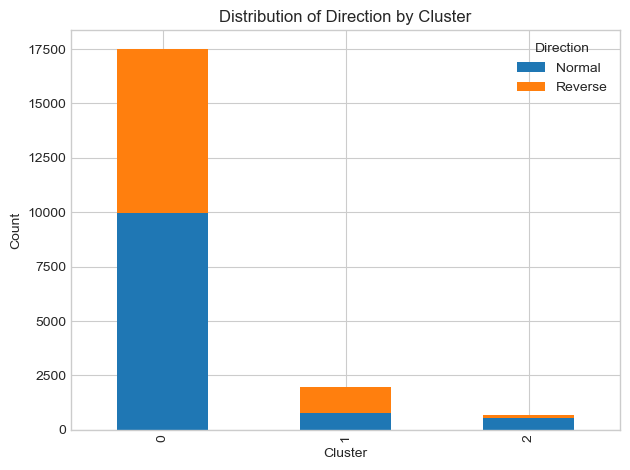

In [36]:
clustered_df, cluster_means = analyze_clusters(features, labels, numeric_cols)

# 11. Identify Distinctive Features for Each Cluster 

In [37]:
def get_distinctive_features(feature_df, labels, numeric_cols):
    """Identify the most distinctive features for each cluster"""
    df_with_clusters = feature_df.copy()
    df_with_clusters['cluster'] = labels
    
    # Calculate z-scores for each numeric feature within each cluster
    cluster_distinctiveness = {}
    
    # First, calculate overall mean and std for each feature
    overall_means = df_with_clusters[numeric_cols].mean()
    overall_stds = df_with_clusters[numeric_cols].std()
    
    # Store feature importance scores
    feature_importance_scores = pd.DataFrame(index=numeric_cols)
    
    for cluster in sorted(df_with_clusters['cluster'].unique()):
        if cluster == -1:  # Skip noise points
            continue
            
        # Get cluster data
        cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster]
        
        # Calculate how much each feature differs from the overall mean (in std units)
        cluster_means = cluster_data[numeric_cols].mean()
        z_scores = (cluster_means - overall_means) / overall_stds
        
        # Store z-scores for this cluster
        feature_importance_scores[f'Cluster {cluster}'] = z_scores.abs()
        
        # Get top distinctive features (highest absolute z-scores)
        distinctive_features = z_scores.abs().sort_values(ascending=False)
        top_features = distinctive_features.head(5)
        
        # Store results
        cluster_distinctiveness[cluster] = {
            'top_features': top_features,
            'mean_values': cluster_means[top_features.index],
            'z_scores': z_scores[top_features.index]
        }
    
    # Print distinctive features for each cluster
    for cluster, data in cluster_distinctiveness.items():
        print(f"\nCluster {cluster} distinctive features:")
        for feature, z_score in data['top_features'].items():
            feature_mean = data['mean_values'][feature]
            direction = "higher" if data['z_scores'][feature] > 0 else "lower"
            print(f"  - {feature}: {abs(z_score):.2f} std {direction} than average (value: {feature_mean:.2f})")
    
    # Plot top features importance across clusters
    plt.figure(figsize=(14, 10))
    sns.heatmap(feature_importance_scores, cmap='YlOrRd', annot=False)
    plt.title('Feature Distinctiveness Across Clusters')
    plt.tight_layout()
    plt.show()
    
    return cluster_distinctiveness, feature_importance_scores


Cluster 0 distinctive features:
  - B Voltage_ptp: 0.39 std lower than average (value: 0.00)
  - B Voltage_max: 0.39 std lower than average (value: 0.00)
  - B Voltage_rms: 0.38 std lower than average (value: 0.00)
  - B Voltage_std: 0.38 std lower than average (value: 0.00)
  - B Voltage_mean: 0.38 std lower than average (value: 0.00)

Cluster 1 distinctive features:
  - B Voltage_rms: 2.57 std higher than average (value: 85.16)
  - B Voltage_mean: 2.57 std higher than average (value: 70.32)
  - B Voltage_ptp: 2.55 std higher than average (value: 117.42)
  - B Voltage_max: 2.55 std higher than average (value: 117.42)
  - B Voltage_std: 2.53 std higher than average (value: 47.20)

Cluster 2 distinctive features:
  - A Voltage_ptp: 5.23 std lower than average (value: 0.02)
  - A Voltage_max: 5.23 std lower than average (value: 0.02)
  - A Voltage_rms: 4.90 std lower than average (value: 0.01)
  - A Voltage_std: 4.62 std lower than average (value: 0.01)
  - A Voltage_mean: 4.55 std lowe

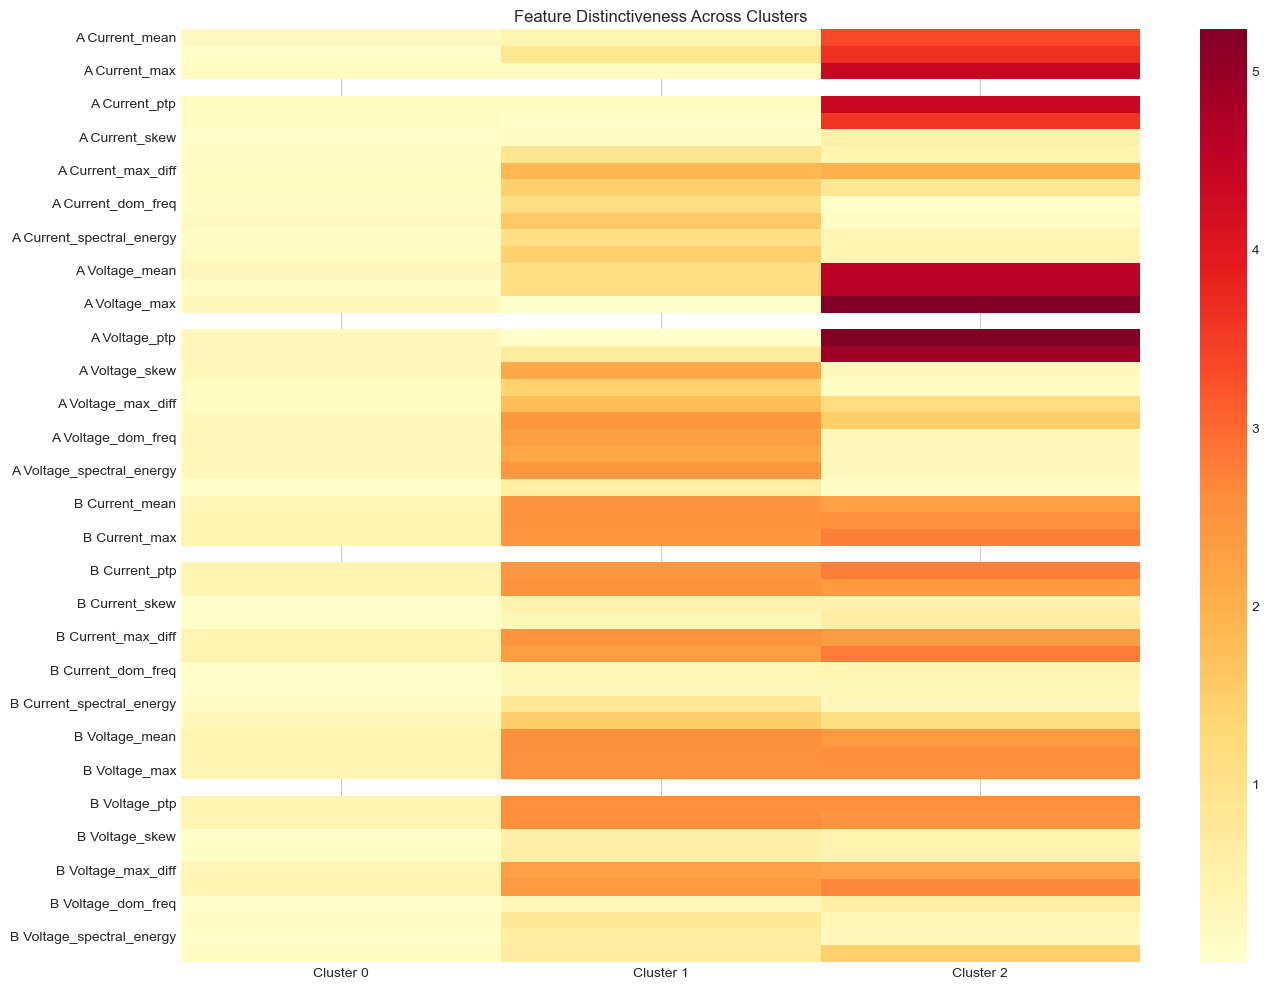

In [38]:
distinctive, importance = get_distinctive_features(features, labels, numeric_cols)


=== Cluster 0 ===


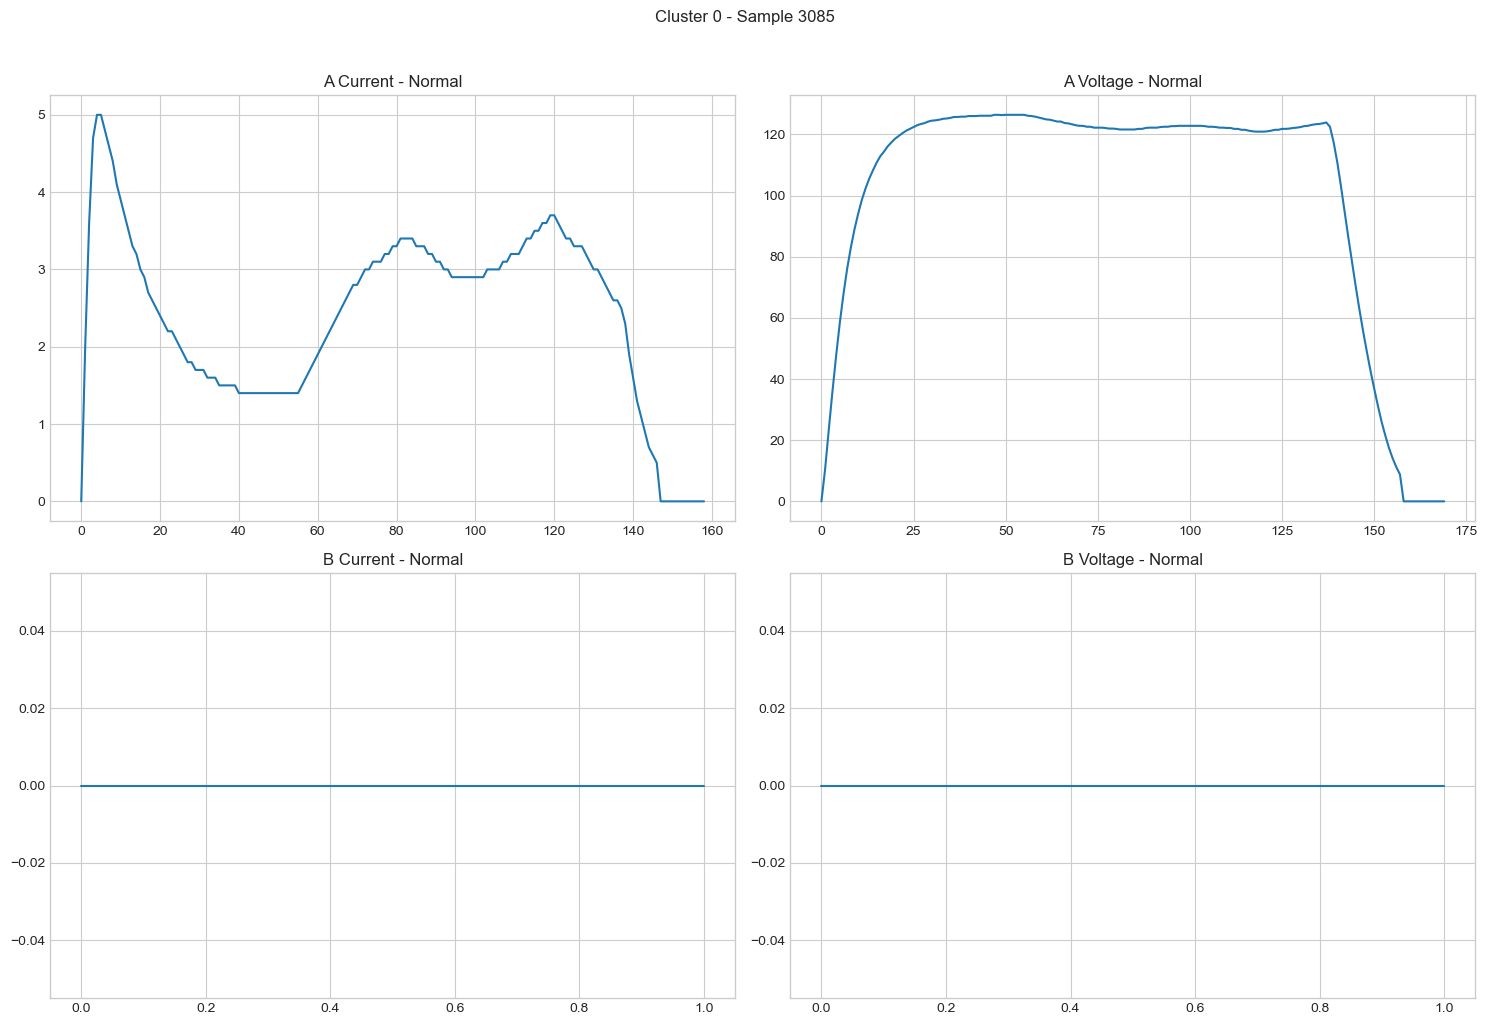

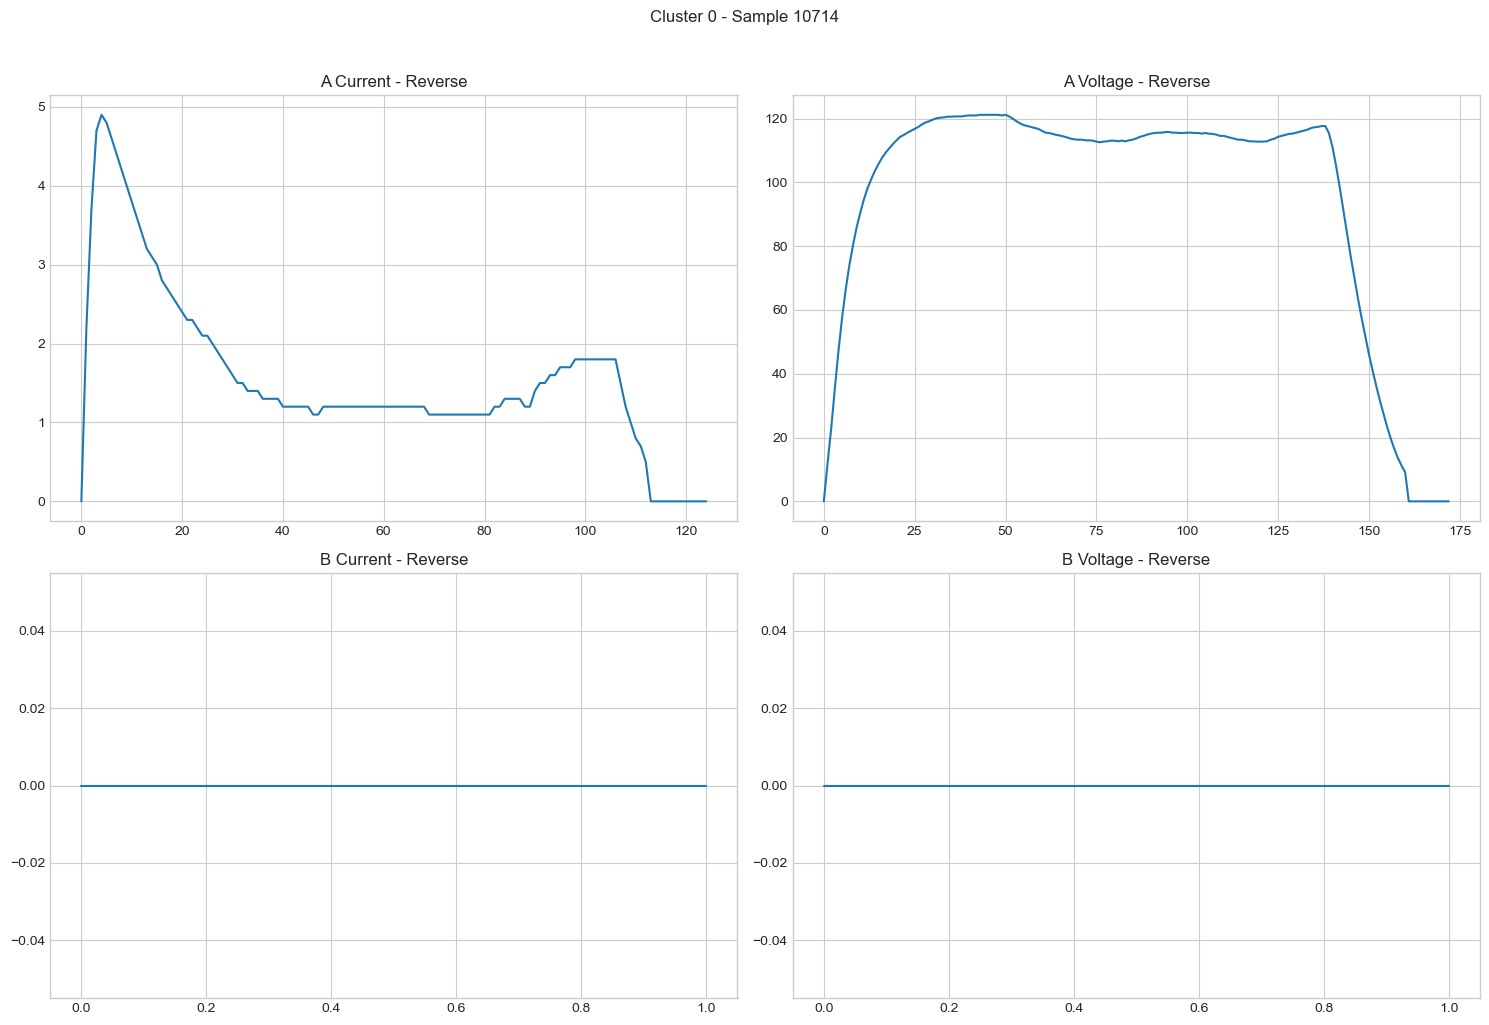

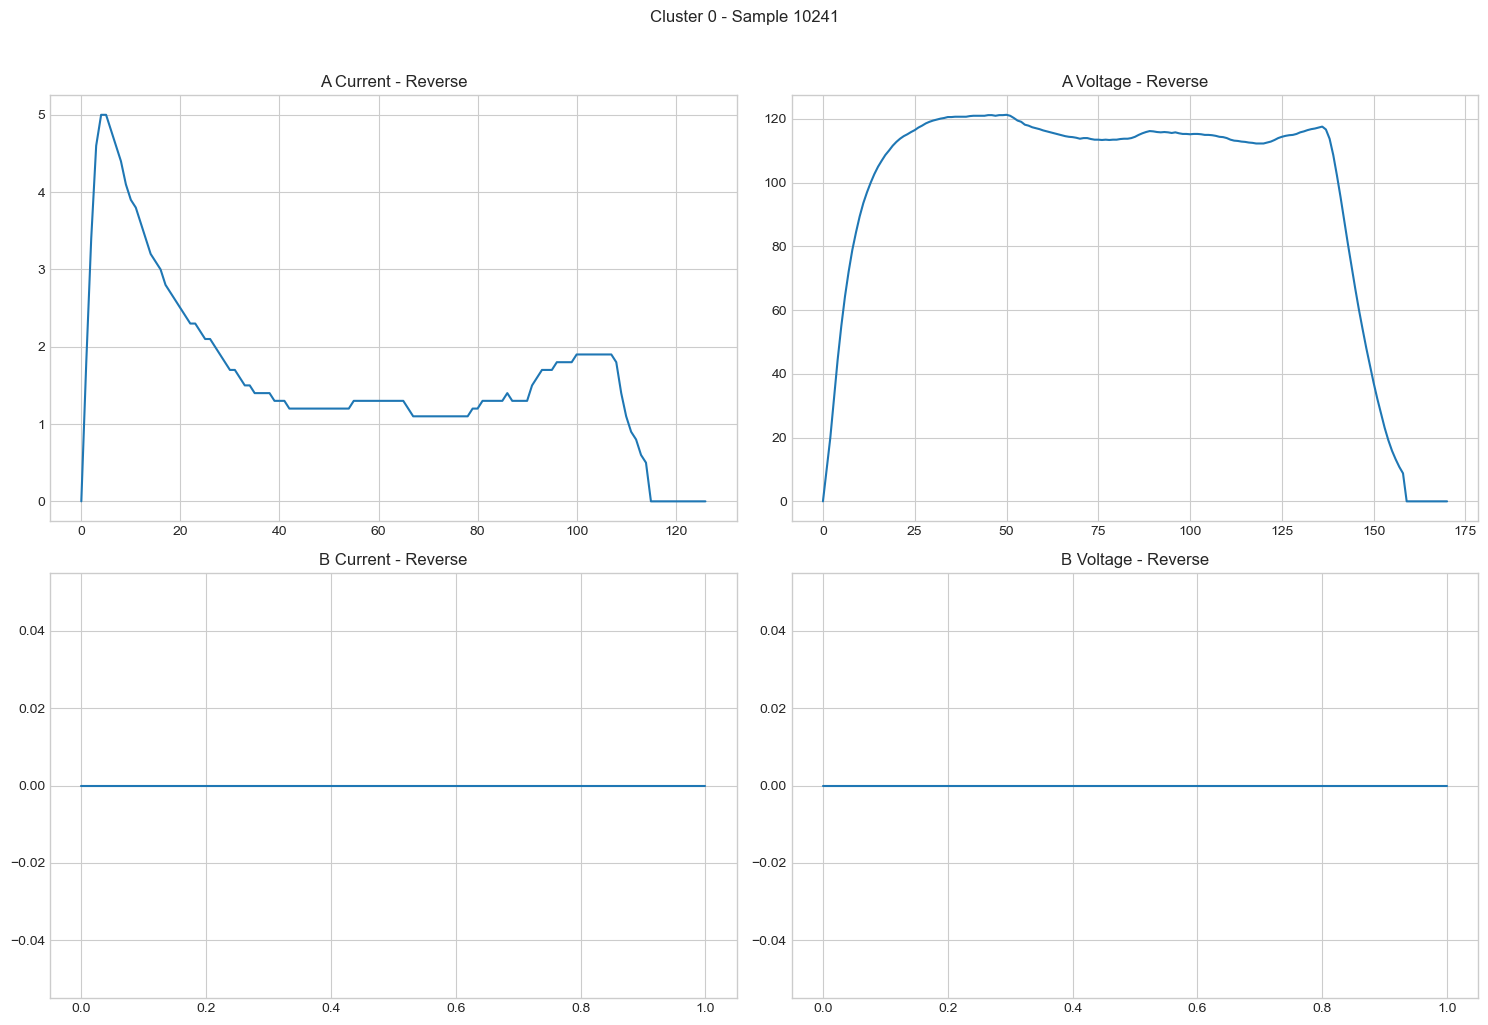


=== Cluster 1 ===


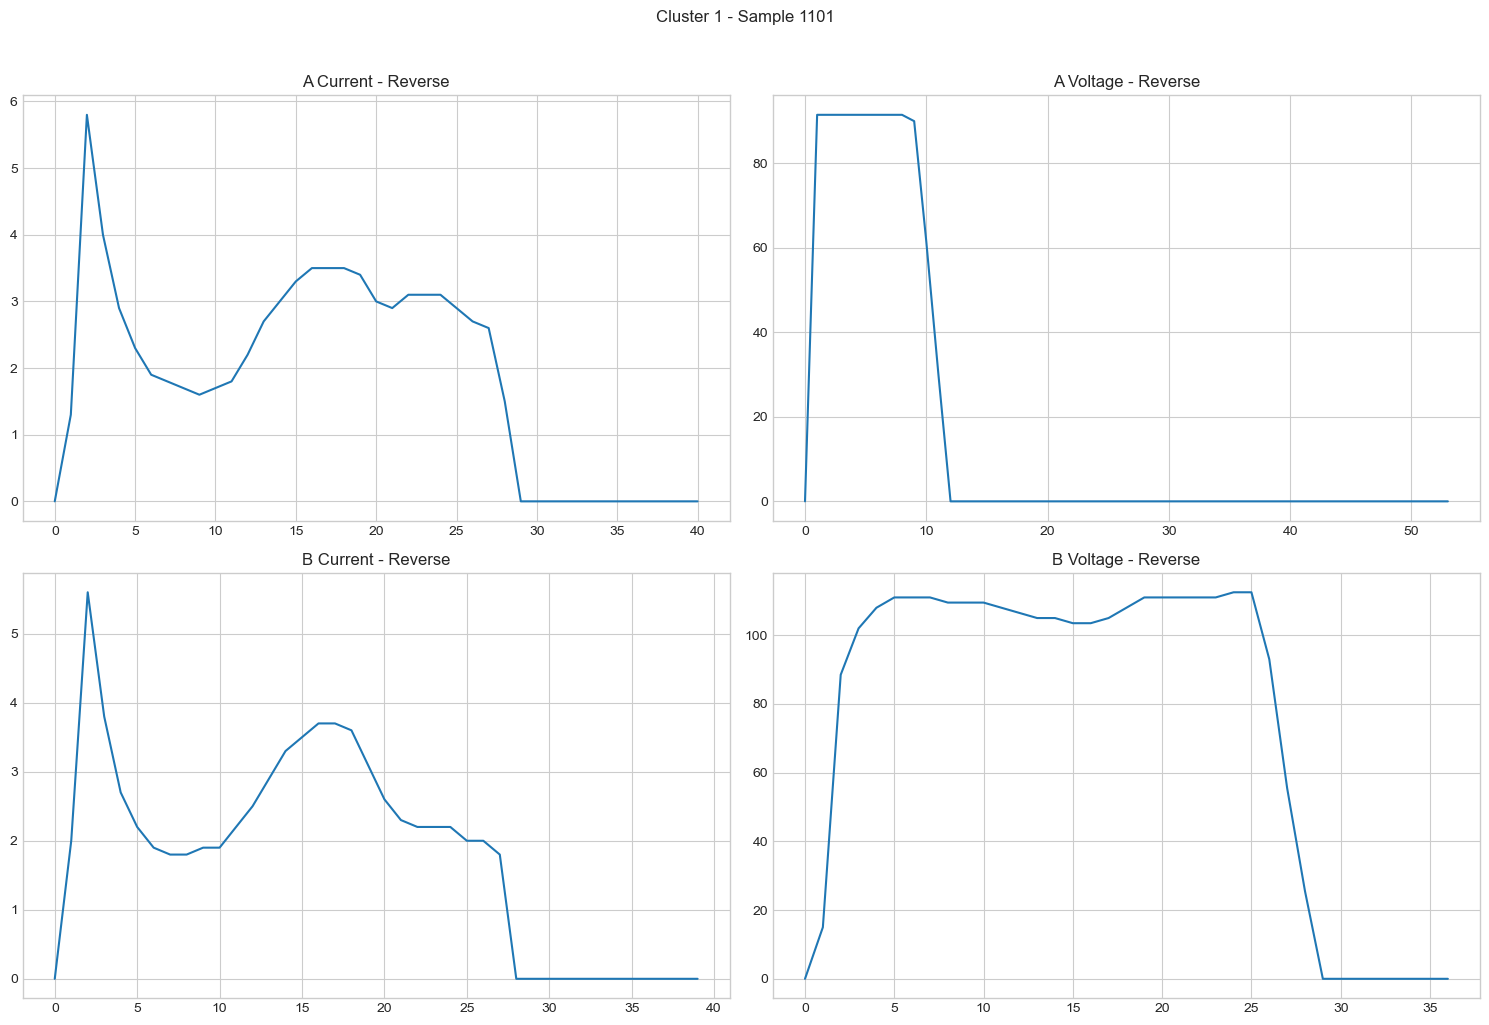

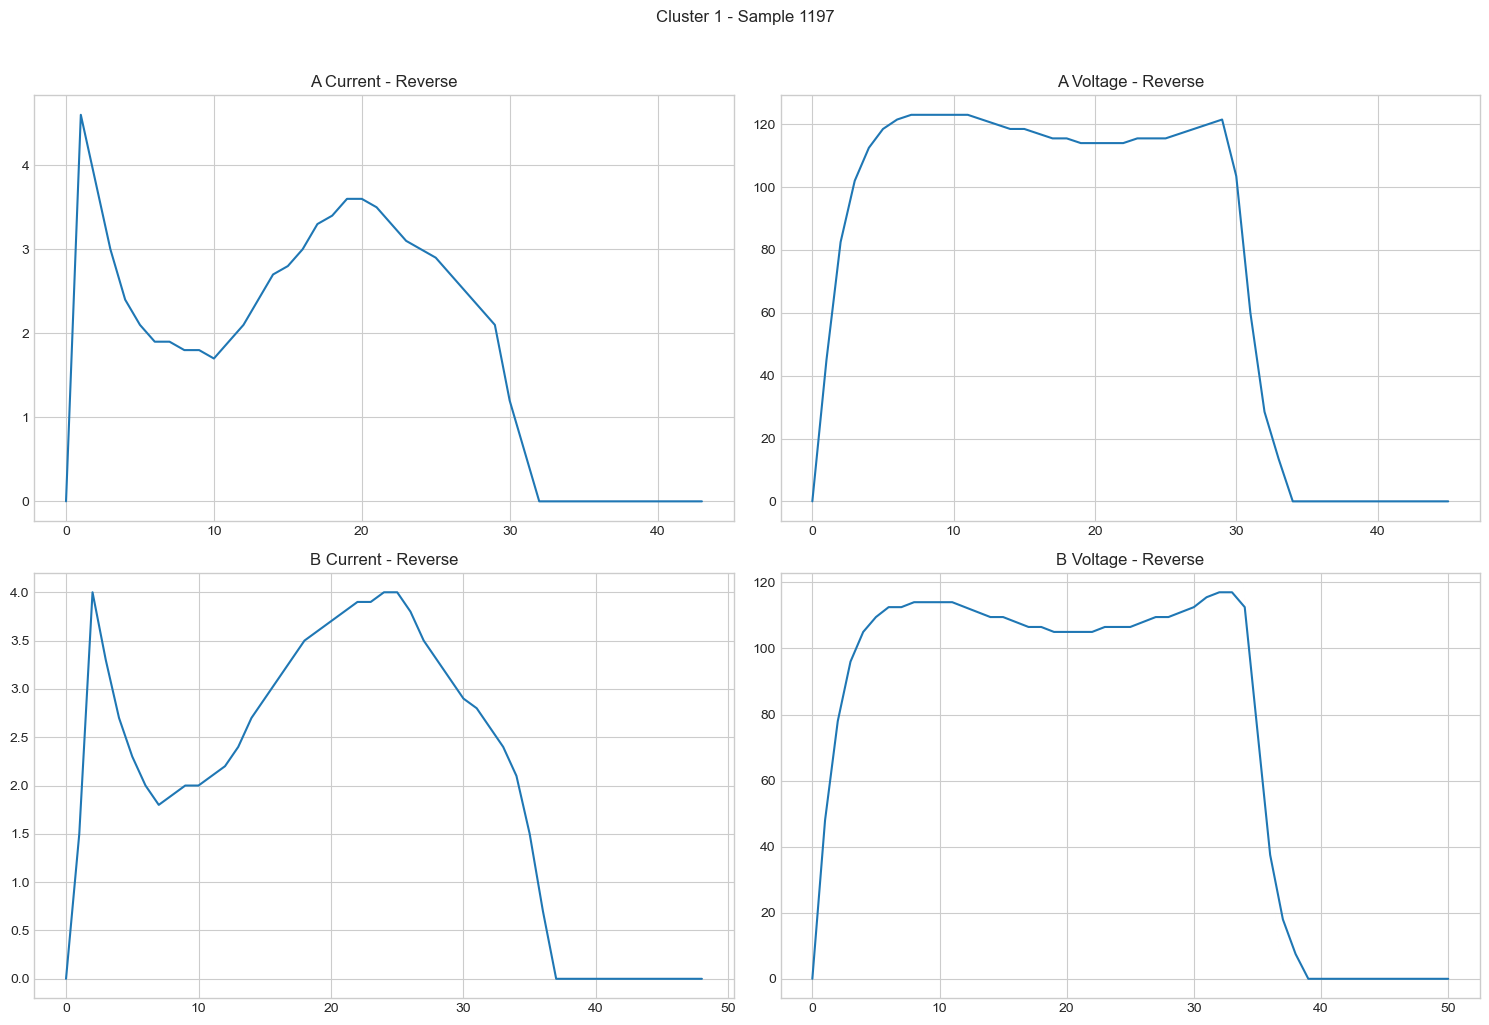

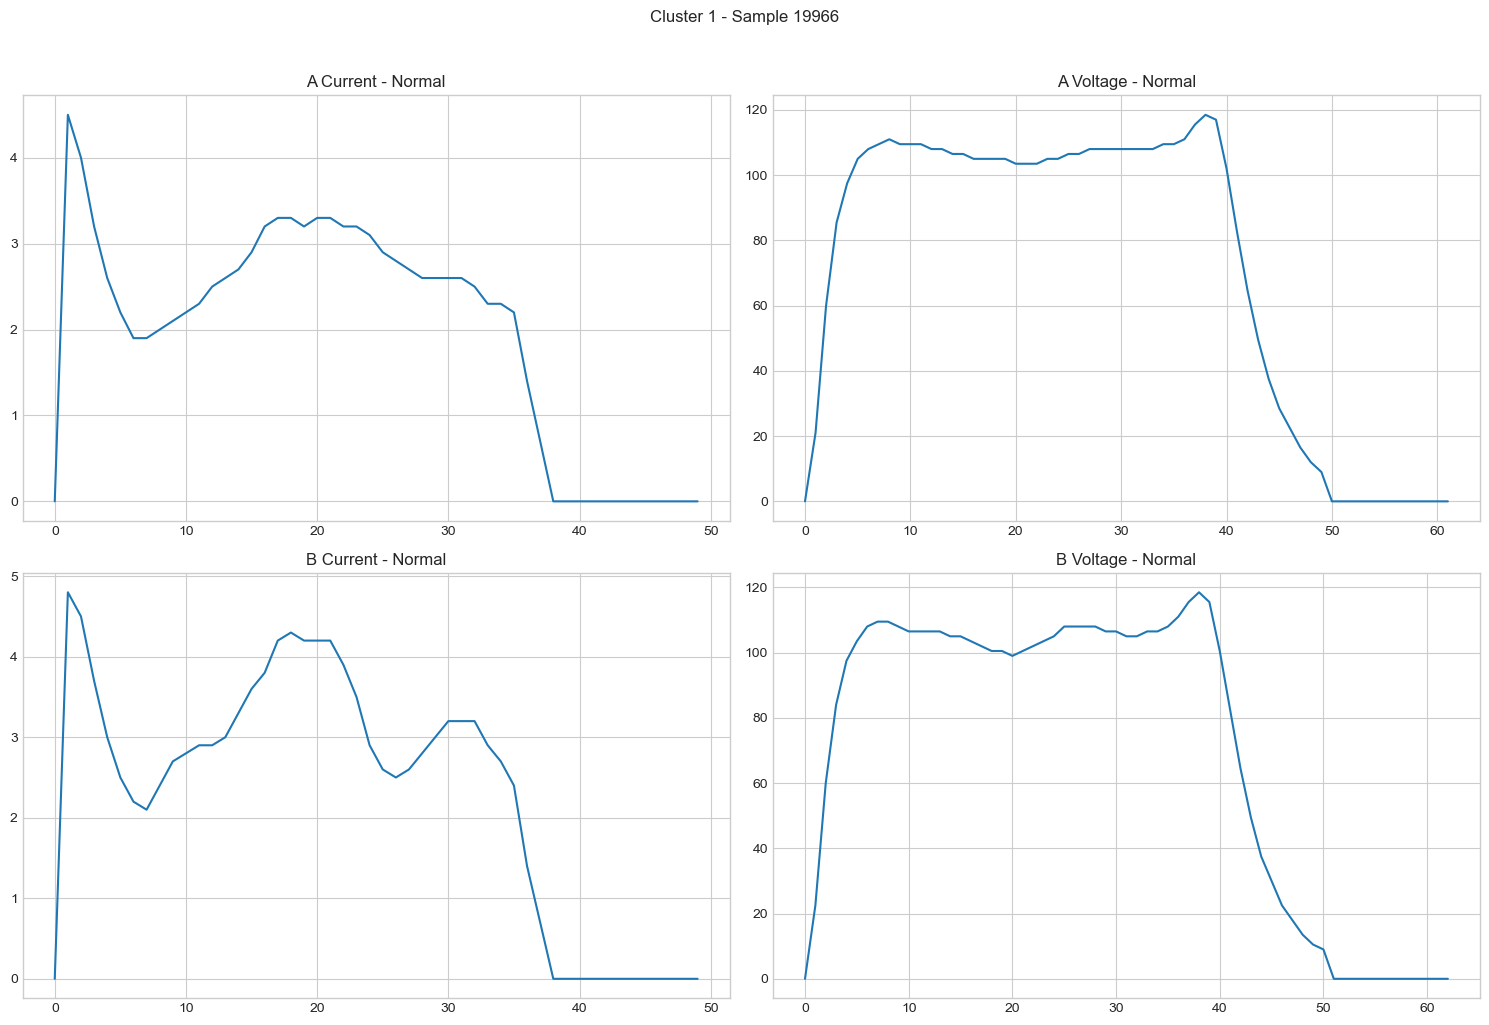


=== Cluster 2 ===


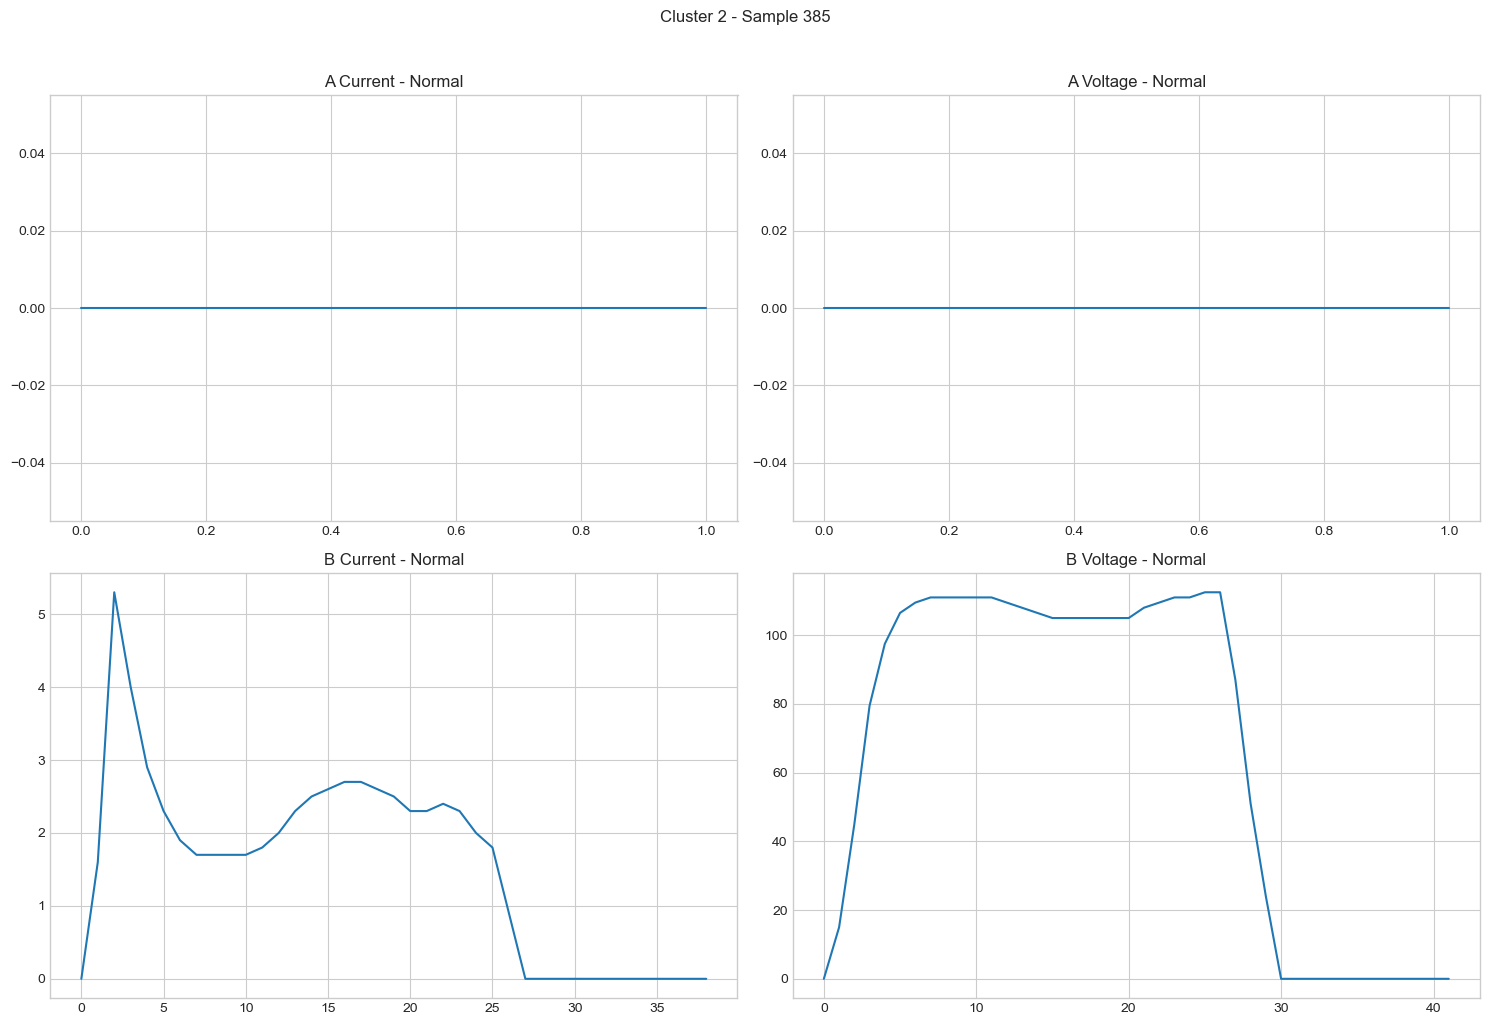

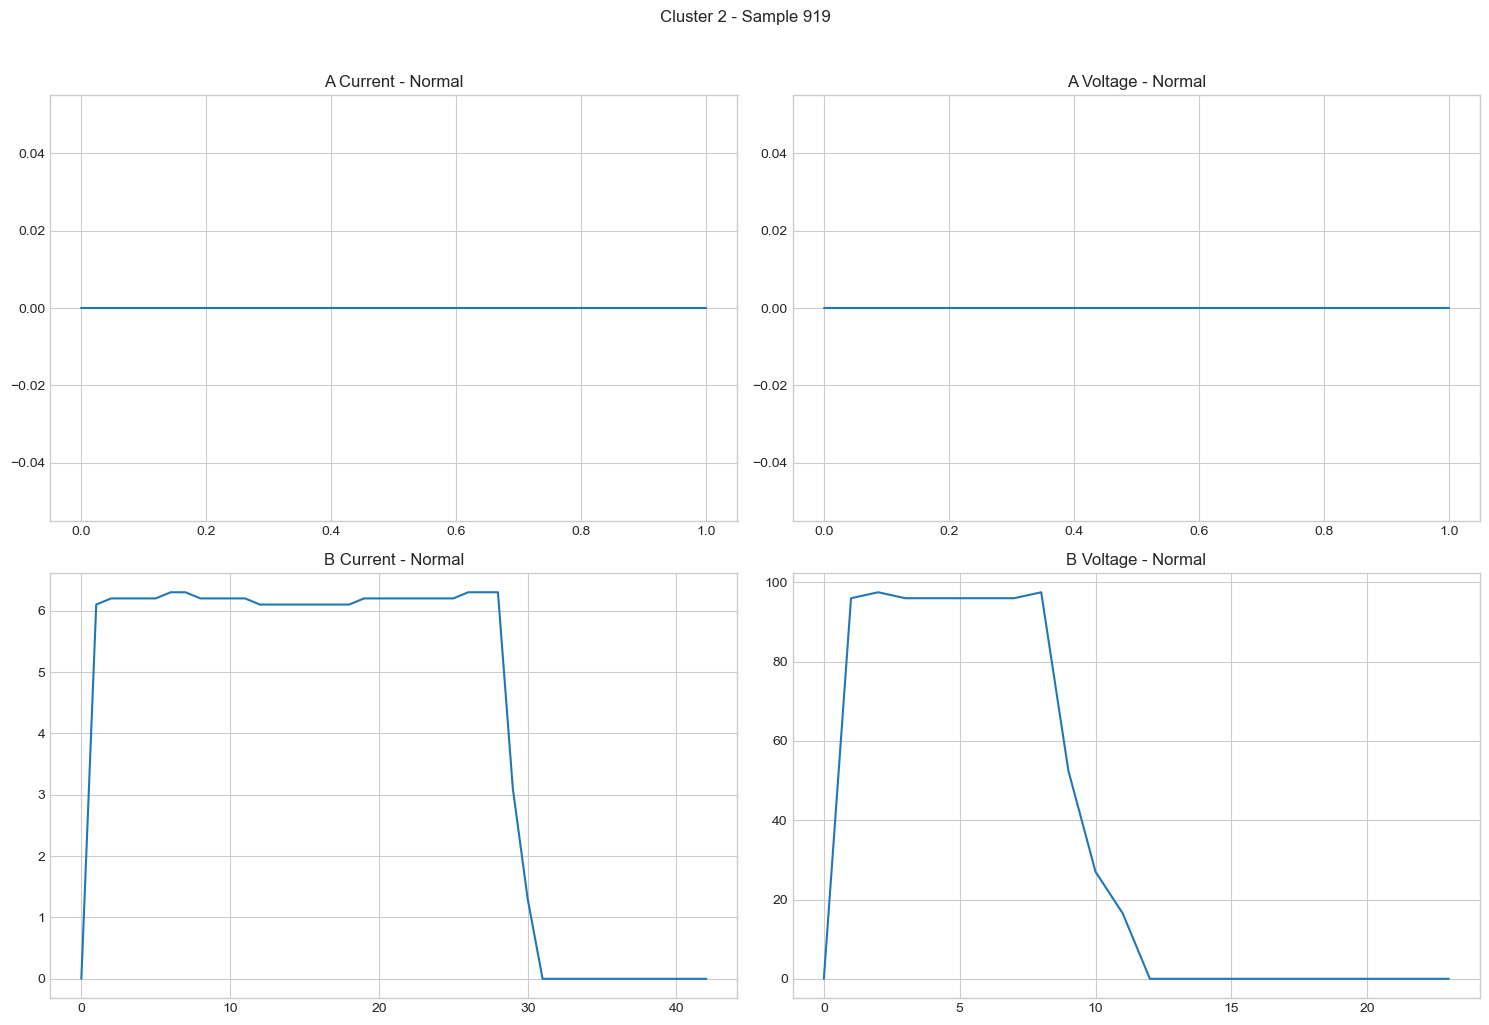

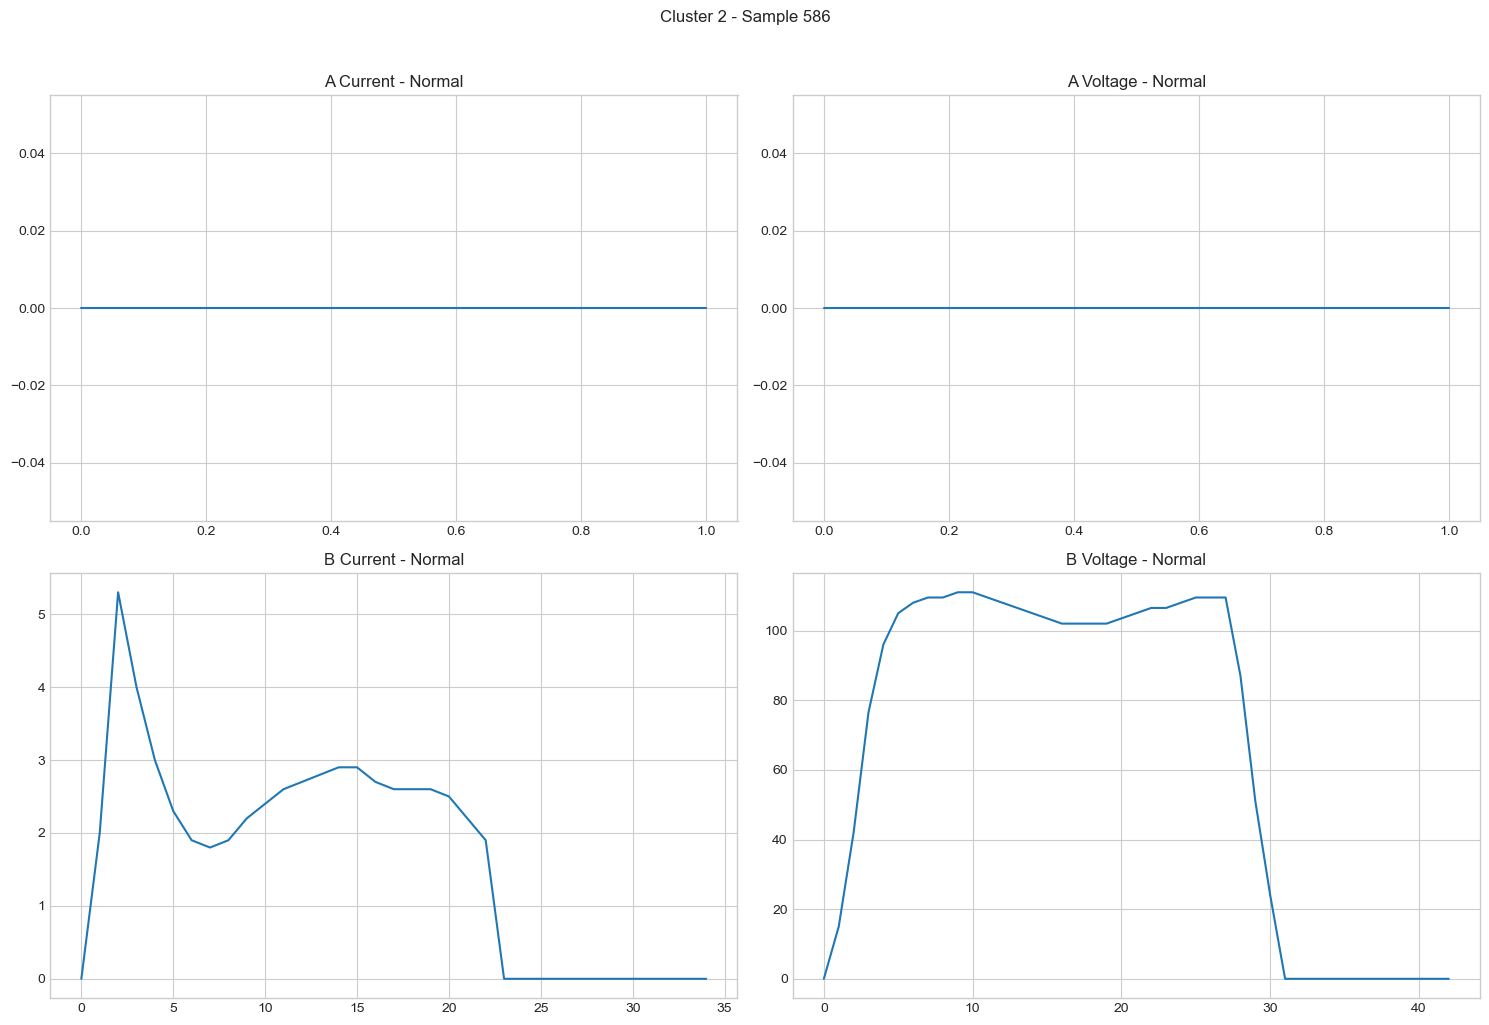

In [41]:
def plot_cluster_signals(df, labels, cluster_id, n_samples=3):
    """Plot raw signals from n_samples in a specific cluster"""
    cluster_samples = df[labels == cluster_id].sample(n_samples)
    
    for idx, row in cluster_samples.iterrows():
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f"Cluster {cluster_id} - Sample {idx}", y=1.02)
        
        # Plot A Current
        if len(row['A Current']) > 0:
            axs[0,0].plot(row['A Current'])
            axs[0,0].set_title(f"A Current - {row['Direction']}")
        
        # Plot A Voltage
        if len(row['A Voltage']) > 0:
            axs[0,1].plot(row['A Voltage'])
            axs[0,1].set_title(f"A Voltage - {row['Direction']}")
        
        # Plot B Current
        if len(row['B Current']) > 0:
            axs[1,0].plot(row['B Current'])
            axs[1,0].set_title(f"B Current - {row['Direction']}")
        
        # Plot B Voltage
        if len(row['B Voltage']) > 0:
            axs[1,1].plot(row['B Voltage'])
            axs[1,1].set_title(f"B Voltage - {row['Direction']}")
        
        plt.tight_layout()
        plt.show()

# Usage: Visualize 3 samples from each cluster
for cluster_id in [0, 1, 2]:
    print(f"\n=== Cluster {cluster_id} ===")
    plot_cluster_signals(df_clean, labels, cluster_id)

# Site Distribution Analysis by Cluster 

<Figure size 1200x600 with 0 Axes>

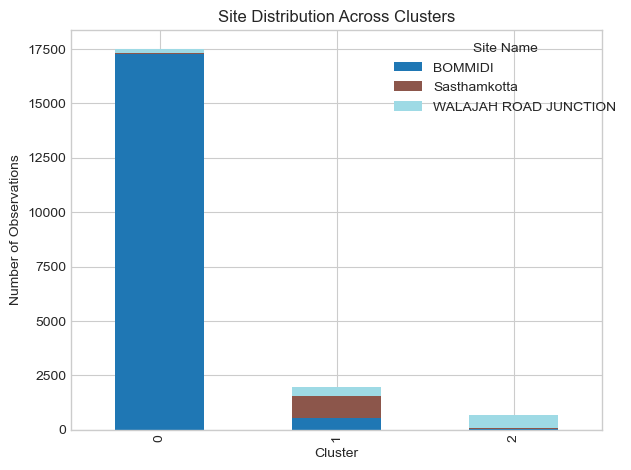


=== Site-Cluster Relationship Details ===

Cluster 0 (Total observations: 17485)
Top Sites:
Site Name
BOMMIDI                  17255
WALAJAH ROAD JUNCTION      149
Sasthamkotta                81
Name: count, dtype: int64

Cluster 1 (Total observations: 1956)
Top Sites:
Site Name
Sasthamkotta             1042
BOMMIDI                   524
WALAJAH ROAD JUNCTION     390
Name: count, dtype: int64

Cluster 2 (Total observations: 688)
Top Sites:
Site Name
WALAJAH ROAD JUNCTION    594
Sasthamkotta              65
BOMMIDI                   29
Name: count, dtype: int64


In [42]:
def analyze_cluster_sites(df, labels):
    """Analyze and visualize site distribution across clusters"""
    # Add cluster labels to DataFrame
    df_clustered = df.copy()
    df_clustered['Cluster'] = labels
    
    # 1. Count sites per cluster
    site_counts = df_clustered.groupby(['Cluster', 'Site Name']).size().unstack(fill_value=0)
    
    # 2. Plot cluster composition by site
    plt.figure(figsize=(12, 6))
    site_counts.plot(kind='bar', stacked=True, colormap='tab20')
    plt.title('Site Distribution Across Clusters')
    plt.ylabel('Number of Observations')
    plt.xlabel('Cluster')
    plt.legend(title='Site Name', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()
    
    # 3. Print detailed site-cluster relationships
    print("\n=== Site-Cluster Relationship Details ===")
    for cluster in sorted(df_clustered['Cluster'].unique()):
        cluster_data = df_clustered[df_clustered['Cluster'] == cluster]
        site_dist = cluster_data['Site Name'].value_counts()
        
        print(f"\nCluster {cluster} (Total observations: {len(cluster_data)})")
        print("Top Sites:")
        print(site_dist.head(10))  # Show top 10 sites per cluster
        
        # Optional: Print machine names for smaller clusters
        if len(cluster_data) < 50:
            print("\nAssociated Point Machines:")
            print(cluster_data[['Site Name', 'Point Machine Name']].value_counts())
    
    return df_clustered

# Usage
df_labeled = analyze_cluster_sites(df_clean, labels)

# Advanced Version (with Direction Analysis) 

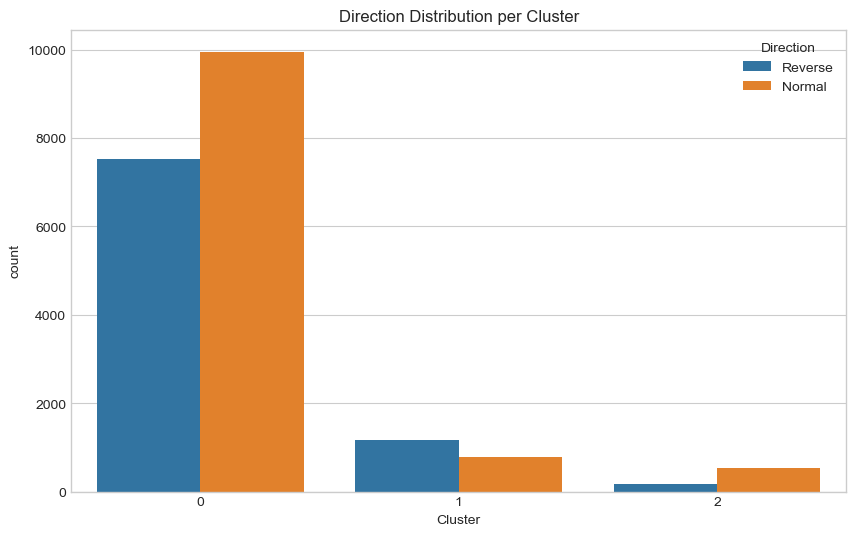

In [44]:
def analyze_cluster_sites_detailed(df, labels):
    df_clustered = df.copy()
    df_clustered['Cluster'] = labels
    
    # Create a cross-tab with site, direction, and cluster
    ct = pd.crosstab(
        index=[df_clustered['Site Name'], df_clustered['Direction']],
        columns=df_clustered['Cluster'],
        margins=True
    )
    
    # Display interactive table (works in Jupyter)
    display(ct.style.background_gradient(cmap='Blues'))
    
    # Plot directional distribution per cluster
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_clustered, x='Cluster', hue='Direction')
    plt.title('Direction Distribution per Cluster')
    plt.show()
    
    return df_clustered

df_labeled = analyze_cluster_sites_detailed(df_clean, labels)